In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6],
                     })


from pida_functions import *

In [2]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df
    
# df = loaddata("data/pida_new_full.root", entry_stop=None, forceit=False)
df = pl.scan_parquet("data/pida_visen.parquet")
# df = pl.scan_parquet('data/pida_new.parquet')
# df = pl.scan_parquet('data/pida_new.parquet')


In [3]:

dftrkg4 = getbestof(df)
# dftrkg4

In [4]:
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


In [5]:
dftmp:pl.DataFrame
if isinstance(dfall, pl.LazyFrame):
    dftmp = dfall.group_by(selection_events(), maintain_order=True).agg(
    ).collect()
    # dftmp = dftmp.head(int(len(dftmp)*0.2))
    # dftmp = dftmp
    # dfall = dfall.join(dftmp.lazy(), on=selection_events()).collect()
    if isinstance(dfall, pl.LazyFrame):
        dfall = dfall.collect()

In [15]:
dfsimple:pl.DataFrame = pl.DataFrame()
dfsimple:pl.DataFrame = pl.DataFrame()
dfsimple_en:pl.DataFrame = pl.DataFrame()
dfsimple_en_old:pl.DataFrame = pl.DataFrame()
dfmus:pl.DataFrame = pl.DataFrame()
dfprselected:pl.DataFrame = pl.DataFrame()
dfprselected:pl.DataFrame = pl.DataFrame()
dfprpiselected:pl.DataFrame = pl.DataFrame()
dfprpiselected:pl.DataFrame = pl.DataFrame()
dfcomplex_en:pl.DataFrame = pl.DataFrame()
dfcomplex_en_full:pl.DataFrame = pl.DataFrame()
def process_data(dfall:pl.DataFrame, cheatmu = False, cheatpi = False, cheatpr = False, minPNC=0.0, saveit=True):
    global dfsimple
    global dfsimple
    global dfsimple_en
    global dfsimple_en_old
    global dfmus
    global dfprselected
    global dfprselected
    global dfprpiselected
    global dfprpiselected
    global dfcomplex_en
    global dfcomplex_en_full
    dfsimple = create_mucandidates(dfall)
    dfsimple_en = simple_energy(dfsimple)
    dfsimple_en_old = simple_energy(dfsimple, forceaddmumass=False)
    if not cheatmu:
        dfmus = create_mucandidates_2(dfall, fineselection=False, afterfine=False)
    else:
        dfmus = create_mucandidates(dfall, cheat=True)
    dfprselected = create_proton_candidate(dfmus, cheat=cheatpi, cheatMinPNC=minPNC)
    dfprselected = join_pi_candidate(dfprselected, dfmus, 'pr')
    dfprpiselected = create_pion_candidate(dfprselected, cheat=cheatpr, cheatMinPNC=minPNC)
    dfprpiselected = join_pi_candidate(dfprpiselected, dfprselected, 'pi')
    dfcomplex_en = complex_energy2(dfprpiselected, W="W", force_bigger_pr=False, do_not_force_bigger_pi=False)
    dfcomplex_en_full = complex_energy2(dfprpiselected, W="W", force_bigger_pr=False, do_not_force_bigger_pi=False, return_full=True)
    # dfcomplex_en_2 = complex_energy2(dfprpiselected, W="W", force_bigger_pr=False, do_not_force_bigger_pi=False, try_hard=False)
    if not saveit:
        return

    dfsimple_en.select(
        dfcomplex_en.drop('Kpi', 'Kpr', 'OtherPFPs', 'mass_to_add').columns
    ).write_parquet("./data/processed/simple.parquet")
    complexname = "complex"
    if cheatmu or cheatpi or cheatpr:
        complexname+="_cheat"
    if cheatmu:
        complexname+="_mu"
    if cheatpi:
        complexname+="_pi"
    if cheatpr:
        complexname+="_pr"
    dfcomplex_en.write_parquet(f"./data/processed/{complexname}.parquet")

minPNC=0.
process_data(dfall, cheatmu=False, cheatpi=False, cheatpr=False, saveit=False, minPNC=minPNC)

In [41]:
pl.Config.set_tbl_rows(100)
dfcomplex_en_full.filter(
    pl.col('run') == 1497,
    pl.col('event').is_between(25200,25400),
    ( (pl.col('selected_lep') ) | (pl.col('selected_pr')) | (pl.col('selected_pi')))
    ).select(
    selection_events('trkId', 'selected_lep', 'selected_pr', 'selected_pi', 'trkpidpida_B','trkg4pdg_planes_B', 'Elep','lepen')
).sort(selection_events('trkId'))

run,subrun,event,trkId,selected_lep,selected_pr,selected_pi,trkpidpida_B,trkg4pdg_planes_B,Elep,lepen
i32,i32,i32,i16,bool,bool,bool,f32,i32,f32,f32
1497,1,25201,0,true,false,false,3.645134,13,1.490233,2.108327
1497,1,25201,1,false,true,false,16.144438,2212,0.0,2.108327
1497,1,25201,2,false,false,true,8.799564,211,0.0,2.108327
1497,1,25203,0,true,false,false,8.071603,13,0.138747,0.137787
1497,1,25205,0,true,false,false,7.914317,13,0.242385,0.244393
1497,1,25205,1,false,true,false,17.440351,2212,0.0,0.244393
1497,1,25207,0,true,false,false,5.718144,13,0.796067,0.69941
1497,1,25210,0,true,false,false,8.333065,13,0.361491,0.361609
1497,1,25210,1,false,true,false,16.084742,2212,0.0,0.361609


In [7]:
# from itertools import product
# possibles = [True, False]
# res = product(possibles, repeat=3)
# for docheats in res:
#     c_mu = docheats[0]
#     c_pi = docheats[1]
#     c_pr = docheats[2]
#     process_data(dfall, cheatmu=c_mu, cheatpi=c_pi, cheatpr=c_pr, minPNC=minPNC)

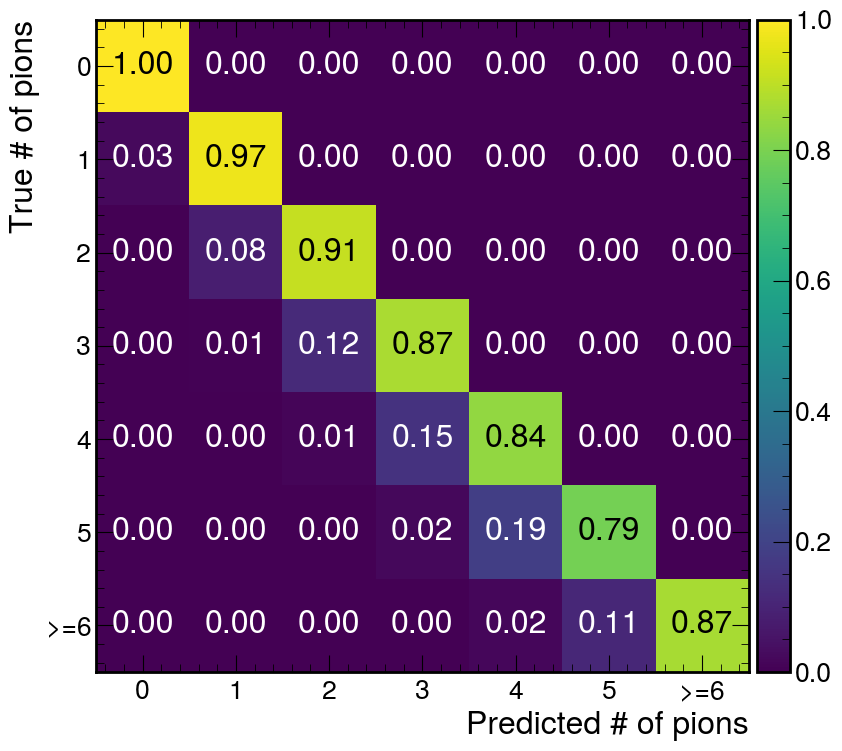

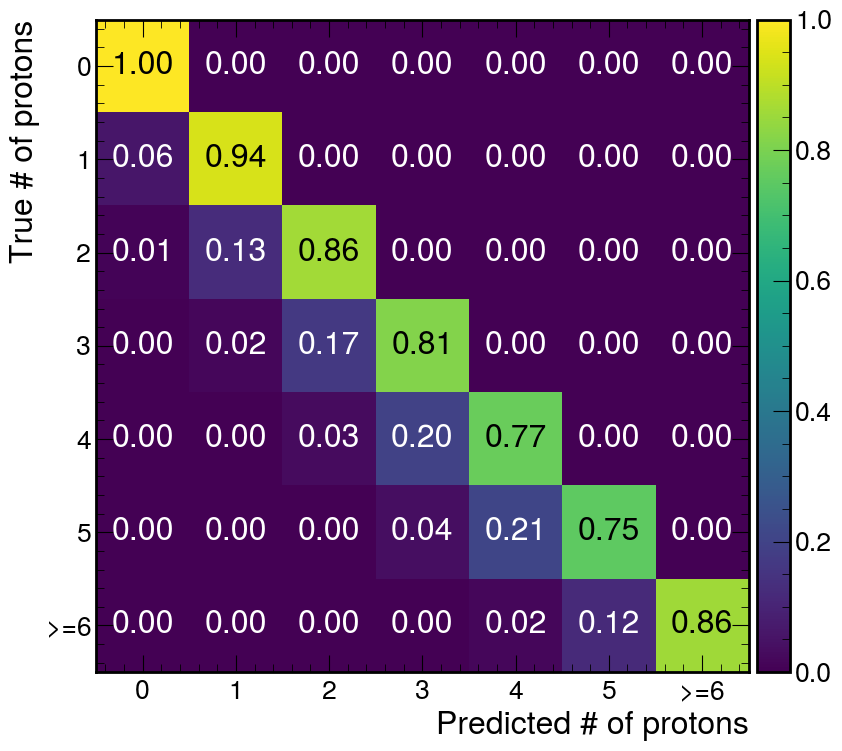

In [8]:
from sklearn import metrics
# dfmatches = dfprpiselected.filter(pl.col('trkPFPIsTrack')).group_by(selection_events(), maintain_order=True).agg(
minPNC=0
dfmatches = dfprpiselected.filter(
        pl.col('pnc') > minPNC
    ).group_by(selection_events(), maintain_order=True).agg(
    pl.col('selected_pi').filter(pl.col('selected_pi')).len().cast(pl.Int32).alias('npi'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(211)).len().cast(pl.Int32).alias('npitruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(211)).unique().len().alias('npitunique'),
    pl.col('selected_pr').filter(pl.col('selected_pr')).len().cast(pl.Int32).alias('npr'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(2212)).len().cast(pl.Int32).alias('nprtruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(2212)).unique().len().alias('nprtunique'),
    pl.col('enu_truth').last(),
    pl.col('lepen').last(),
).with_columns(
    ratio_pi = ( pl.col('npi')-pl.col('npitruth') ),
    ratio_pr = ( pl.col('npr')-pl.col('nprtruth') )
)

nmax=6
classes = [0,1,2,3,4,5,">=6"]
dfmatches = dfmatches.with_columns(
    pl.when(pl.col('npi')>nmax).then(nmax).otherwise(pl.col('npi')).alias('npi'),
    pl.when(pl.col('npitruth')>nmax).then(nmax).otherwise(pl.col('npitruth')).alias('npitruth'),
    pl.when(pl.col('npr')>nmax).then(nmax).otherwise(pl.col('npr')).alias('npr'),
    pl.when(pl.col('nprtruth')>nmax).then(nmax).otherwise(pl.col('nprtruth')).alias('nprtruth'),
)

confusion_matrix_pi = metrics.confusion_matrix(dfmatches['npitruth'], dfmatches['npi'])
# print(confusion_matrix_pi)
# print(confusion_matrix_pi.sum())
confusion_matrix_pi = np.array([ line/total for line, total in zip(confusion_matrix_pi, confusion_matrix_pi.sum(1))])
# print(confusion_matrix_pi)

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pi)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pi[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pi.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pi[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of pions')
plt.xlabel('Predicted # of pions')
plt.show()

confusion_matrix_pr = metrics.confusion_matrix(dfmatches['nprtruth'], dfmatches['npr'])
confusion_matrix_pr = np.array([ line/total for line, total in zip(confusion_matrix_pr, confusion_matrix_pr.sum(1))])

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pr)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pr[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pr.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pr[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of protons')
plt.xlabel('Predicted # of protons')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


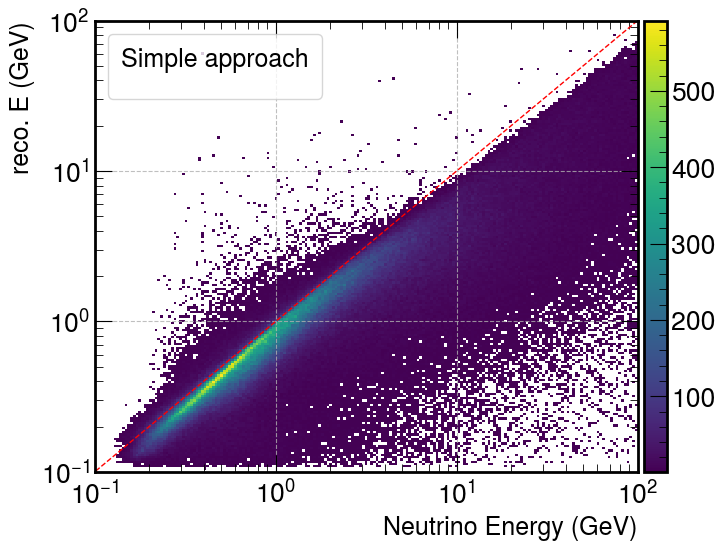

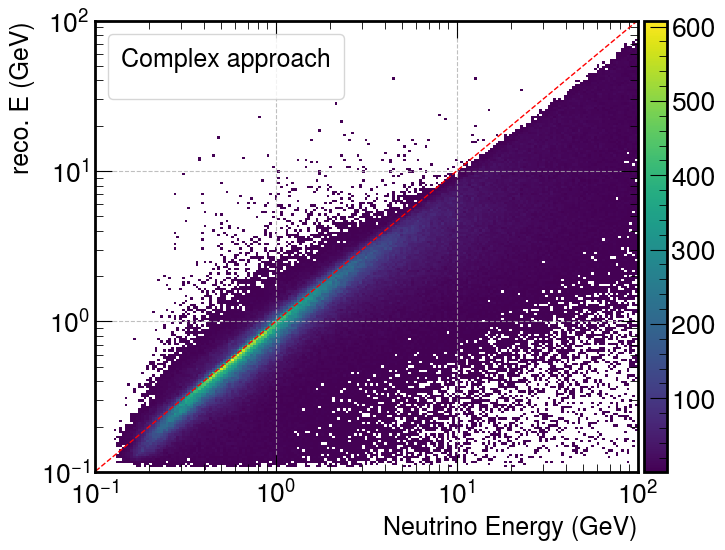

In [48]:
def plot_en_vs_en(Emu:pl.DataFrame,
                  lmethod,
                  x='enu_truth',
                  y='Etotal',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  zscale='linear'
                  ):

    fig = plt.figure(figsize=figsize)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1,2,200)
    # binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=18
    # fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=zscale, cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Neutrino Energy (GeV)', fontsize=fontsize)
    plt.ylabel(f'reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    plt.plot([0,100],[0,100], 'r--', lw=1)
    # dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")


dfsimple_en = dfsimple_en.filter(
    True,
    # ~pl.col('trkIsContained')
    # pl.col('hasmu')
)
binse=None
# binse=np.logspace(np.log10(50),2,100)
binsereco = binse
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfcomplex_en, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
# plot_en_vs_en(dfcomplex_en_2, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


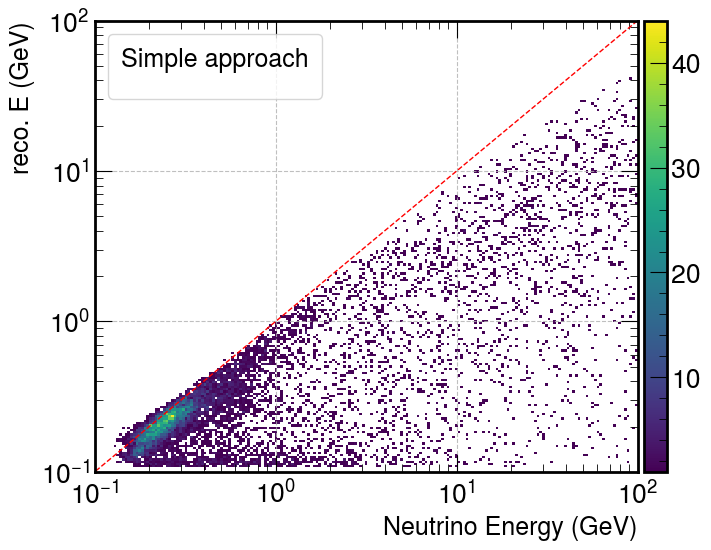

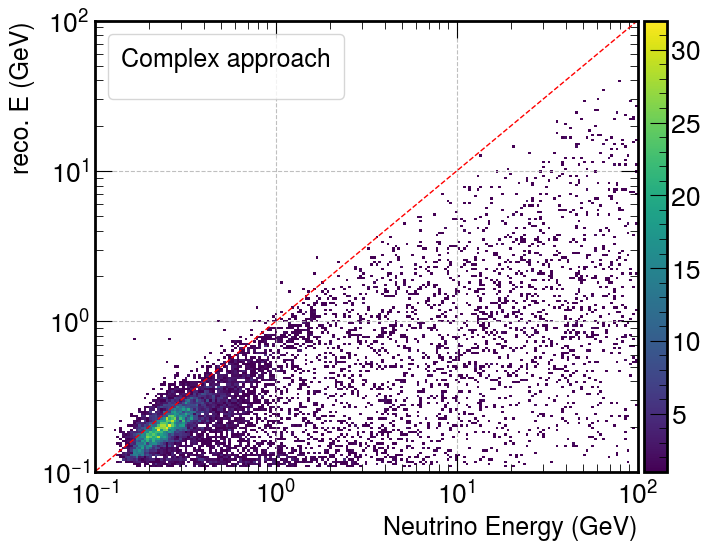

In [49]:
dflost = dfsimple_en.filter(~pl.col('selected_mu'))
dfrecovered = dfcomplex_en.join(dflost.select(selection_events()), on=selection_events())
plot_en_vs_en(dflost, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfrecovered, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(1, 0, 'Muon True Energy [GeV]')

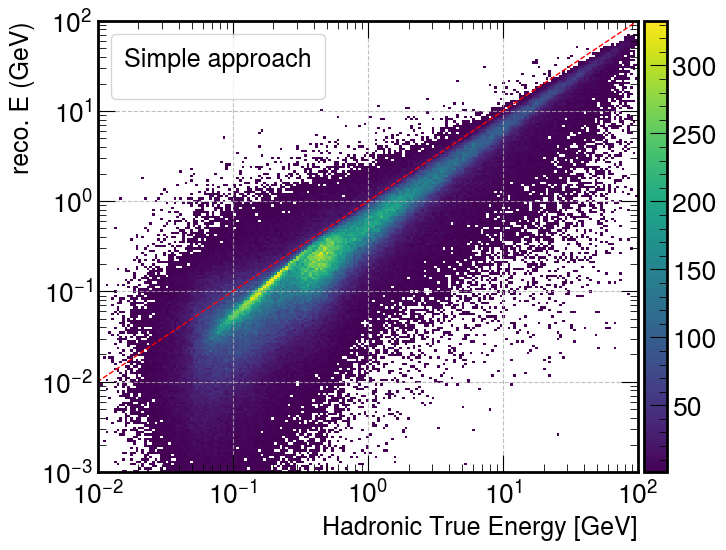

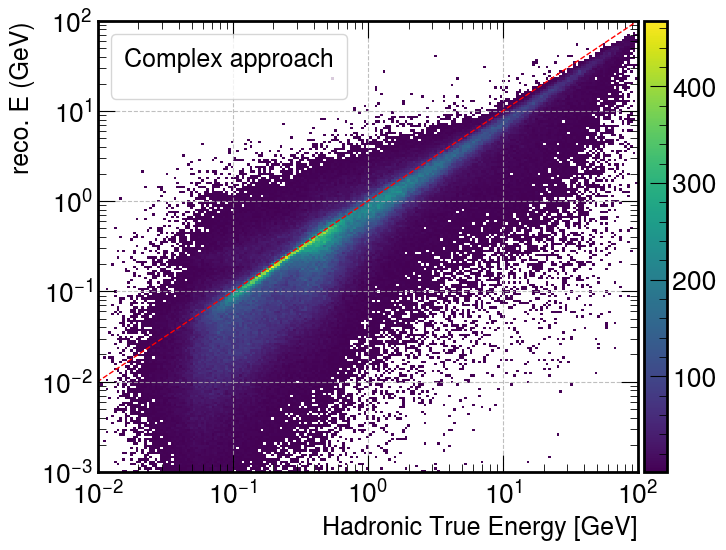

<Figure size 1400x600 with 0 Axes>

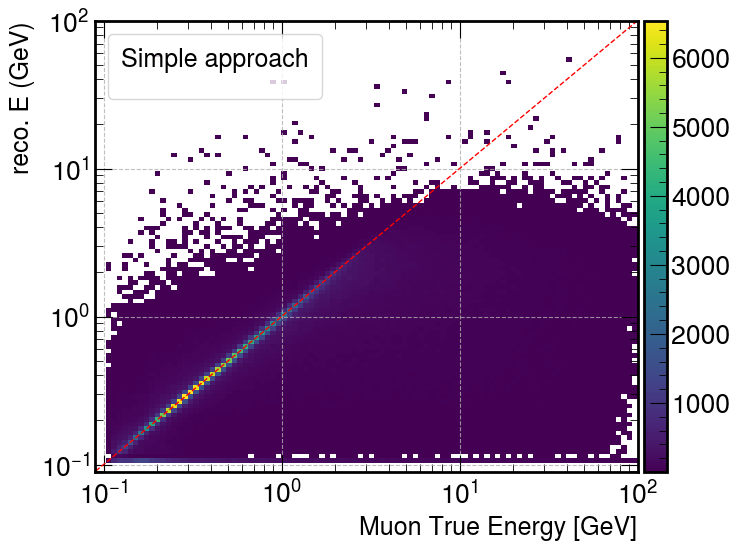

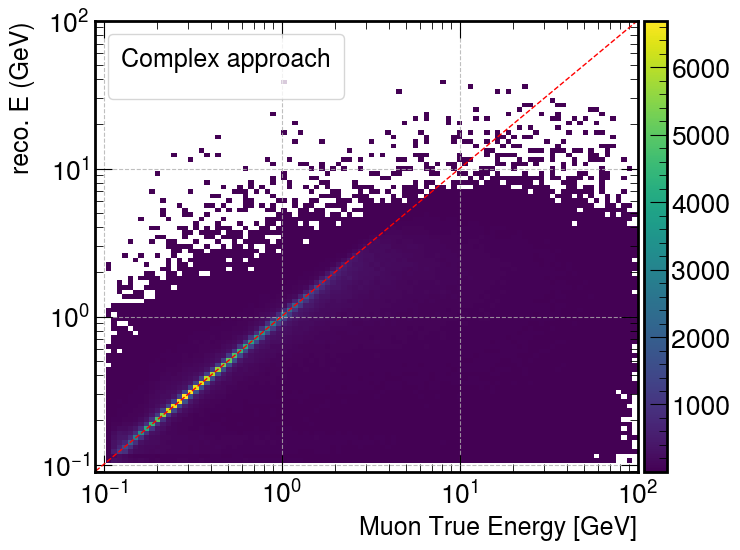

In [50]:
binse=None
binse=np.logspace(-2,2,200)
binsereco = binse
binsereco=np.logspace(-3,2,200)
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plot_en_vs_en(dfcomplex_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plt.figure()
binse=np.logspace(-1.05,2,100)
binsereco = binse
# binsereco = np.logspace(-1,2,100)
zscale='linear'
plot_en_vs_en(dfsimple_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale=zscale)
plt.xlabel('Muon True Energy [GeV]')
plot_en_vs_en(dfcomplex_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale=zscale)
plt.xlabel('Muon True Energy [GeV]')

In [51]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Neutrino Energy [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0.3,
                    ypre = 0.93,
                    # titlesize='xx-large',
                    titlesize=None,
                    legendsize=None,
                    **kwargs):
    x = x.filter(y>0)
    y = y.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        if title=='':
            title = 'Mean'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize=titlesize, fontsize=legendsize)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    # dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")

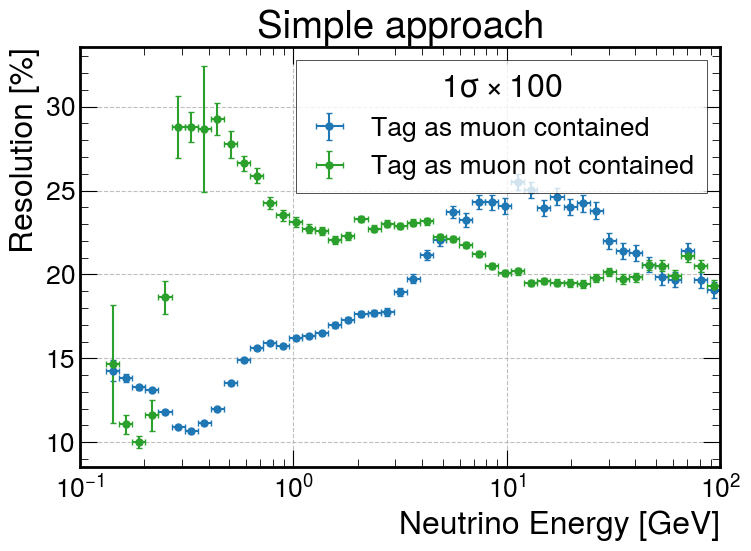

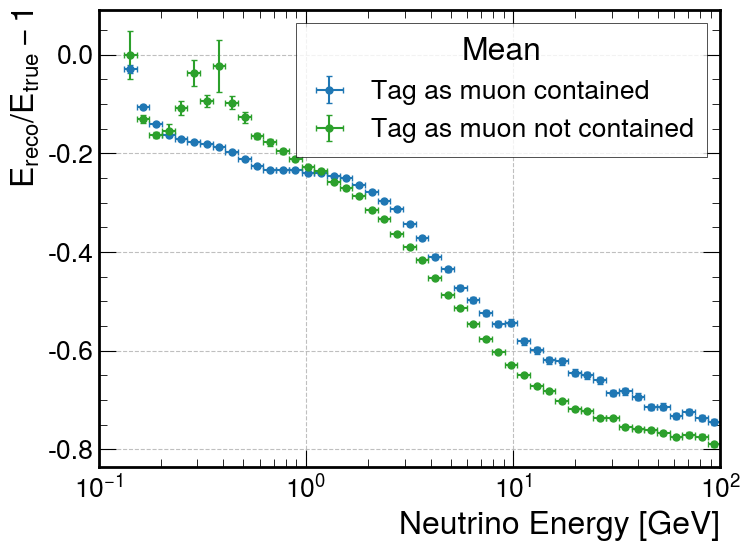

In [52]:
binsx= np.logspace(-1,2,50)
xscale='log'
capsize=2
label='LLHD'
plt.figure(figsize=(8,6))
x='lepmom'
y='Pmu'
x='enu_truth'
y='Etotal'
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    color='C2'
)
plt.savefig('graphs/simple_res.png')
# plt.ylim(0,60)
plt.title('Simple approach')

plt.figure(figsize=(8,6))
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
    infotype='mean',
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    infotype='mean',
    color='C2'
)

plt.savefig('graphs/simple_bias.png')

(-0.85, 0.15)

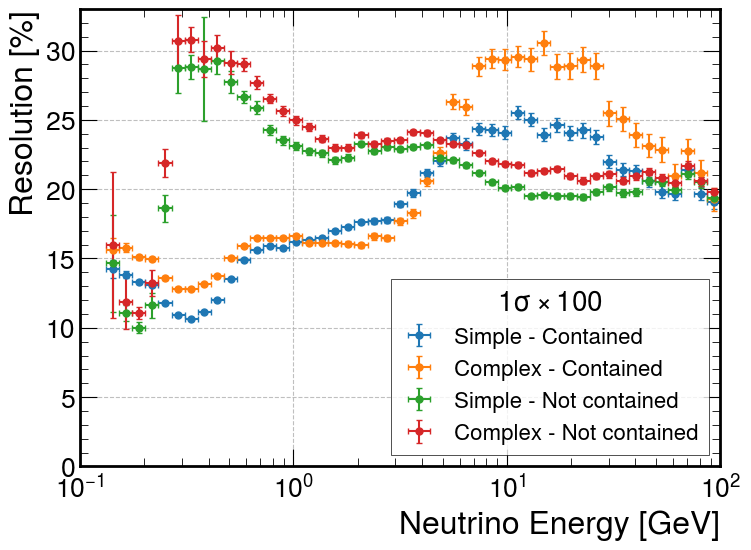

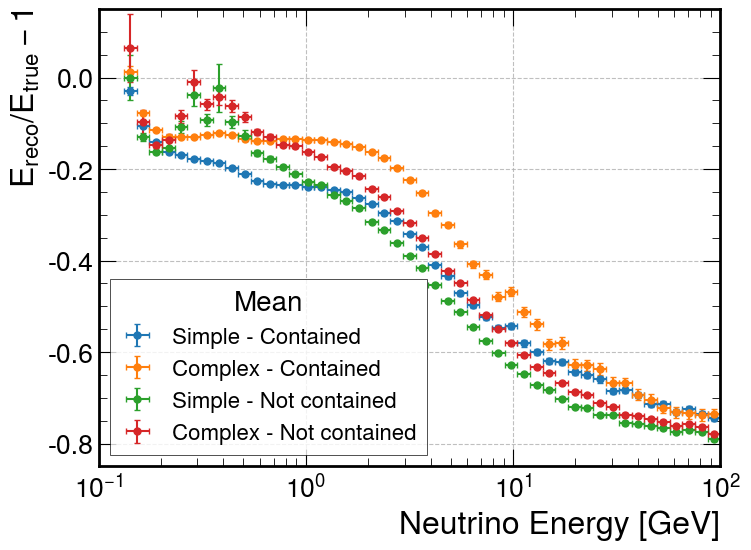

In [53]:
commonargs = dict(
    binsx= np.logspace(-1,2,50),
    xscale='log',
    capsize=2,
)
def the_res_scatter(labels = None, infotype="std", *args, **kargs):
    commonargs = dict(
        binsx= np.logspace(-1,2,50),
        xscale='log',
        capsize=2,
        legendsize=16,
        titlesize=20,
        colorscontained=['C0','C1'],
        colorsnotcontained=['C2','C3'],
    )
    for k in commonargs.keys():
        if k not in kargs.keys():
            kargs[k] = commonargs[k]
    
    x='enu_truth'
    y='Etotal'
    if 'x' in kargs.keys():
        x=kargs.pop('x')
    if 'y' in kargs.keys():
        y=kargs.pop('y')
    if labels is None:
        labels = [ i for i, _ in enumerate(args)]
    plt.figure(figsize=(8,6))
    thecolors_c = kargs.pop('colorscontained')
    thecolors_nc = kargs.pop('colorsnotcontained')
    for df, label, c in zip(args, labels, thecolors_c):
        plot_res_scatter(
            df.filter(pl.col('trkIsContained'))[x],
            df.filter(pl.col('trkIsContained'))[y],
            label=f"{label} - Contained",
            infotype=infotype,
            color=c,
            **kargs,
        )
    for df, label, c in zip(args, labels, thecolors_nc):
        plot_res_scatter(
            df.filter(~pl.col('trkIsContained'))[x],
            df.filter(~pl.col('trkIsContained'))[y],
            label=f"{label} - Not contained",
            infotype=infotype,
            color=c,
            **kargs,
        )
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(0,33)
# plt.savefig('graphs/numu_res.png')
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(-0.85,0.15)
# plt.savefig('graphs/numu_bias.png')


In [54]:
dfall.group_by(selection_events(),maintain_order=True).agg(
    (pl.col('trkcalo_planes_W')).filter(pl.col('trkcalo_planes_W')==0).len().alias('nzeros'),
    (pl.col('trkcalo_planes_W')).len().alias('nall')
).with_columns(
    frac = pl.col('nzeros')/pl.col('nall')
).filter(
    pl.col('nzeros')>2
)

run,subrun,event,nzeros,nall,frac
i32,i32,i32,u32,u32,f64
1498,1,22003,3,7,0.428571
1498,1,24480,3,8,0.375
1497,1,77349,3,14,0.214286
1497,1,77389,3,10,0.3
1497,1,40664,3,14,0.214286
…,…,…,…,…,…
6492179,1,77817,3,11,0.272727
50546594,1,68443,3,3,1.0
1793,1,90925,3,6,0.5


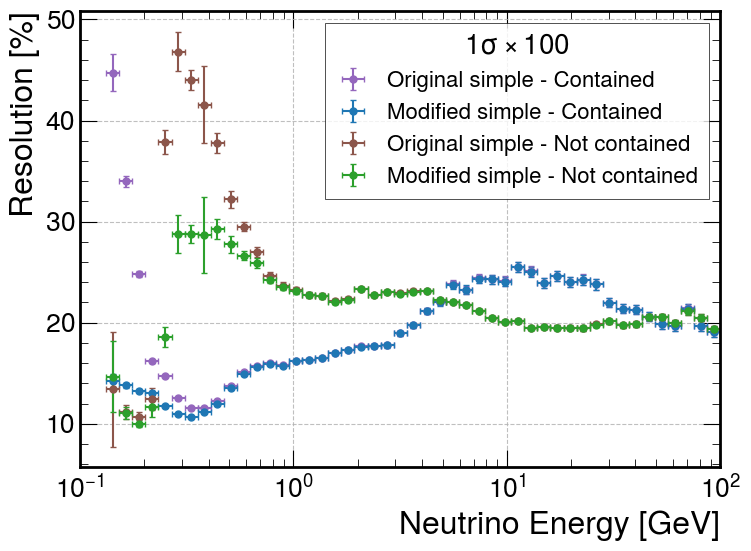

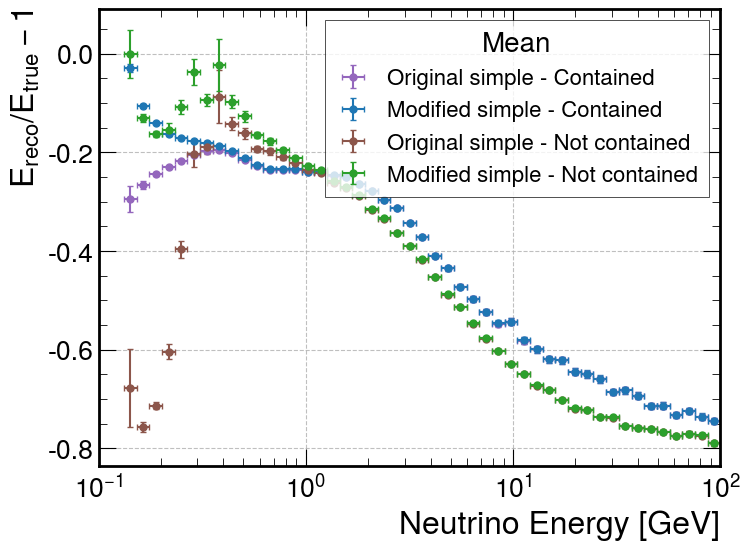

In [56]:
tmpargs = commonargs.copy()
tmpargs['colorscontained']=['C4','C0']
tmpargs['colorsnotcontained']=['C5','C2']
# print(tmpargs)
the_res_scatter(["Original simple","Modified simple"], "std", dfsimple_en_old, dfsimple_en, **tmpargs)
# plt.ylim(0,None)
the_res_scatter(["Original simple","Modified simple"], "mean", dfsimple_en_old, dfsimple_en, **tmpargs)

Text(1, 0, 'Hadronic True Energy [GeV]')

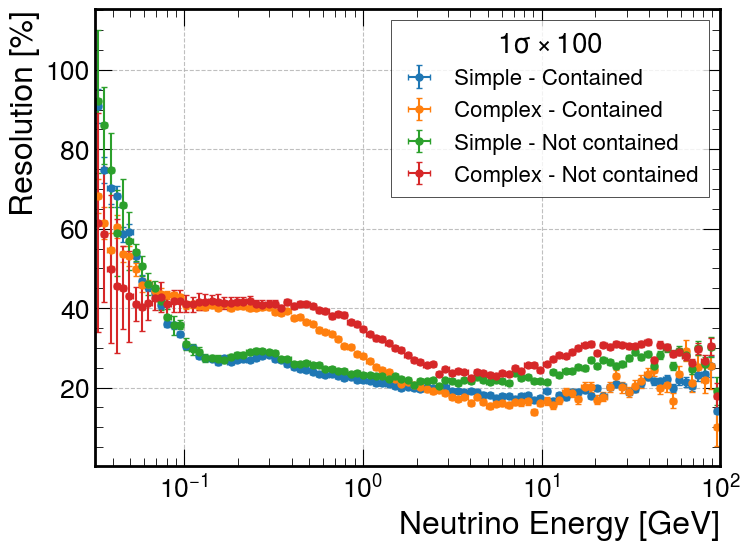

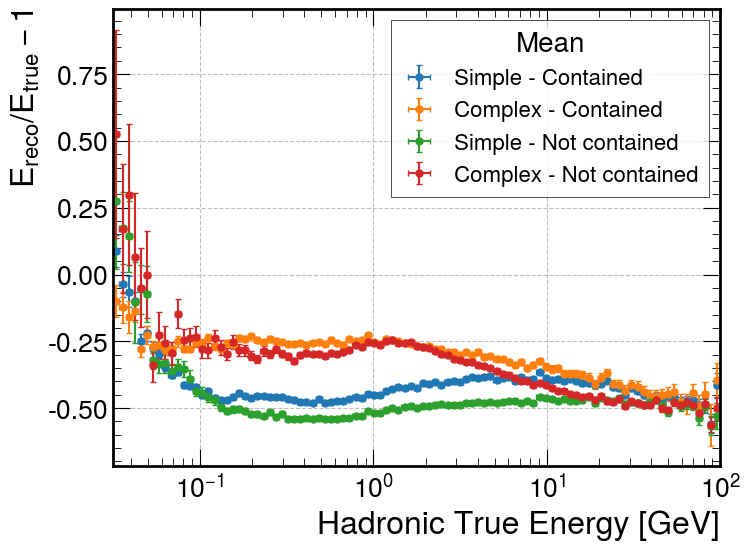

In [58]:

tmpargs = commonargs.copy()
tmpargs['binsx'] = np.logspace(-1.5,2,100)
tmpargs['x'] = 'had_truth'
tmpargs['y'] = 'Ehad'
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **tmpargs)
# plt.ylim(0,None)
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **tmpargs)
plt.xlabel('Hadronic True Energy [GeV]')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 1, 'Reco K [GeV]')

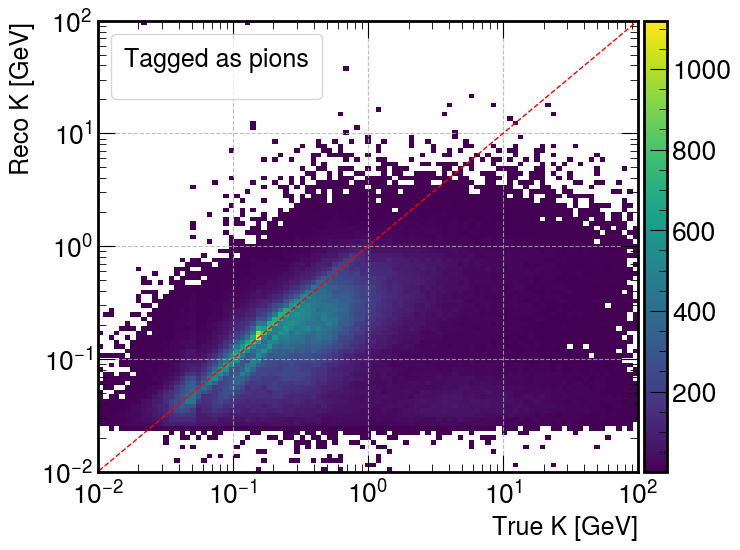

In [63]:
pty='i'
lmethod='Tagged as pions'
if pty!='i':
    lmethod='Tagged as protons'
plot_en_vs_en(dfcomplex_en_full.filter(
                pl.col(f'selected_p{pty}'),
                # pl.col('pnc')>0.8,
                # pl.col('trkIsContained'),
                # ~isparticle(2212),
                ),
              lmethod=lmethod,
              x='trkg4K',
              y=f'Kp{pty}',
              zscale='linear',
              binsx=np.logspace(-2,2,100),
              binsy=np.logspace(-2,2,100),
              )
plt.xlabel('True K [GeV]')
plt.ylabel('Reco K [GeV]')

(-0.85, 0.35)

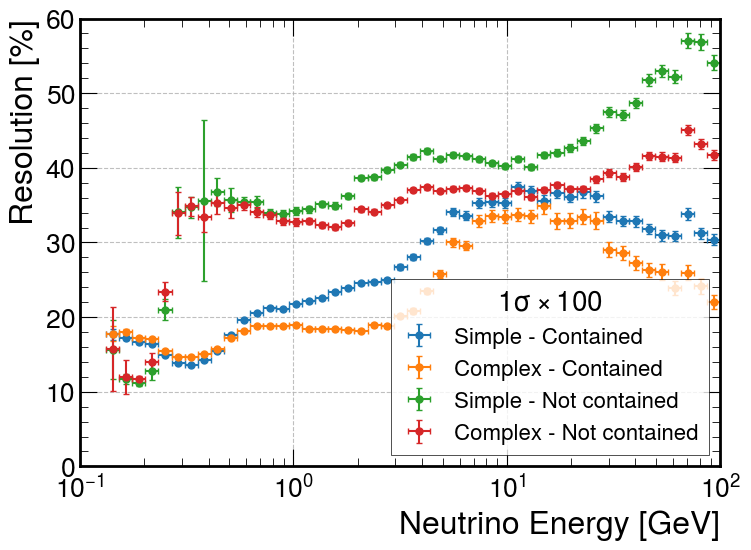

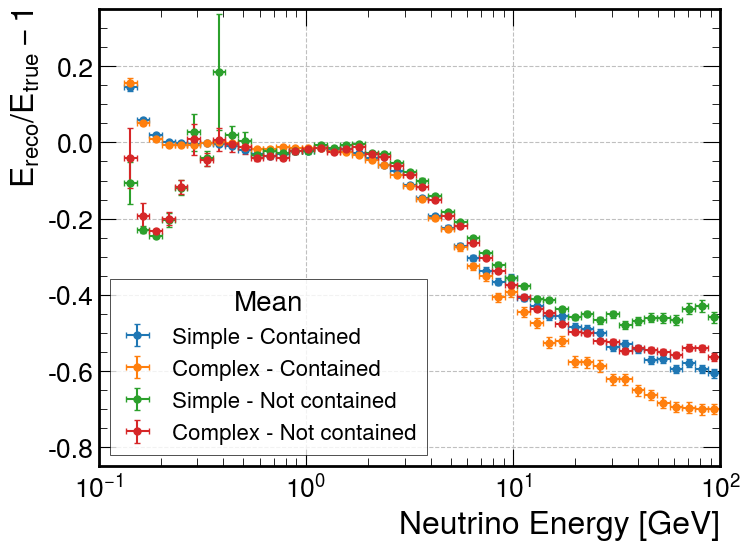

In [60]:
dfsimple_scaled = dfsimple_en.with_columns(
    pl.when(pl.col('trkIsContained')).then((pl.col("Etotal")**1.05)*1.3).otherwise(
        (pl.col('Etotal')**1.2)*1.3
    )
)
dfcomplex_scaled = dfcomplex_en.with_columns(
    pl.when(pl.col('trkIsContained')).then((pl.col("Etotal"))*1.14).otherwise(
        ((pl.col('Etotal'))**1.15)*1.18
        # pl.col('Etotal')
    )
)
the_res_scatter(["Simple","Complex"], "std", dfsimple_scaled, dfcomplex_scaled, **commonargs)
plt.ylim(0,60)
# plt.savefig('graphs/numu_res.png')
the_res_scatter(["Simple","Complex"], "mean", dfsimple_scaled, dfcomplex_scaled, **commonargs)
plt.ylim(-0.85,0.35)
# plt.savefig('graphs/numu_bias.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


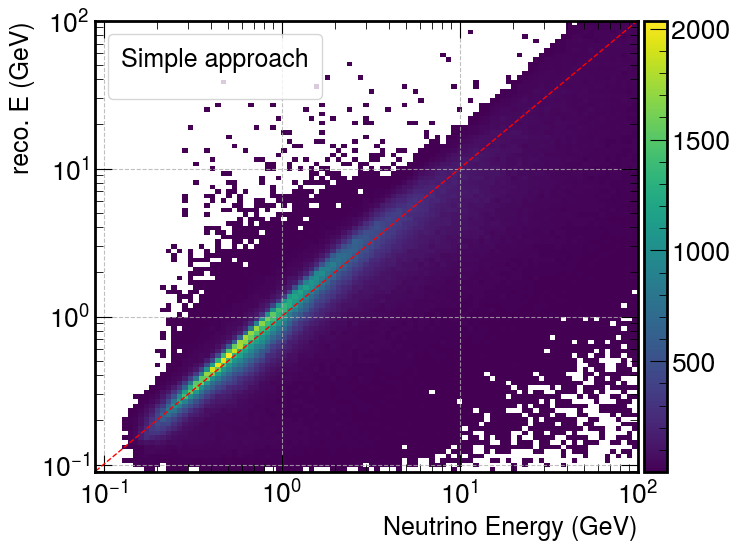

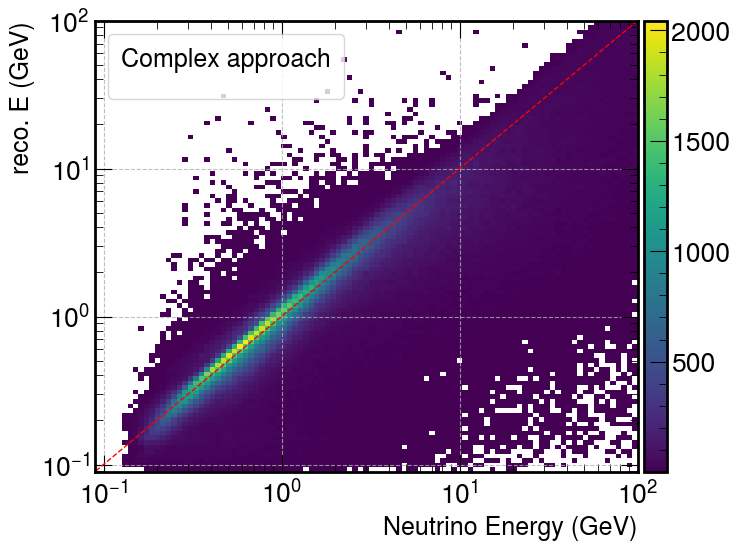

In [61]:
plot_en_vs_en(dfsimple_scaled, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfcomplex_scaled, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')